# Импорт библиотек

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from transformers import ViTForImageClassification
from transformers import ViTConfig, ViTForImageClassification
from datasets import load_dataset
from datasets import Dataset
from torch.utils.data import  Subset
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
import torch.optim as optim
from torchvision import models, transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DF = pd.read_excel('/content/data_8_30160.xlsx')
DF['id'] = DF['id'].fillna('').astype(str)
DF.to_excel('data_8_new.xlsx', index = False)

# Загрузка данных

In [ ]:
data = pd.read_excel("/content/data_8_new.xlsx")
data= Dataset.from_pandas(data)
data

Dataset({
    features: ['id', 'IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH'],
    num_rows: 3169
})

# Распределение по классам биомаркеров

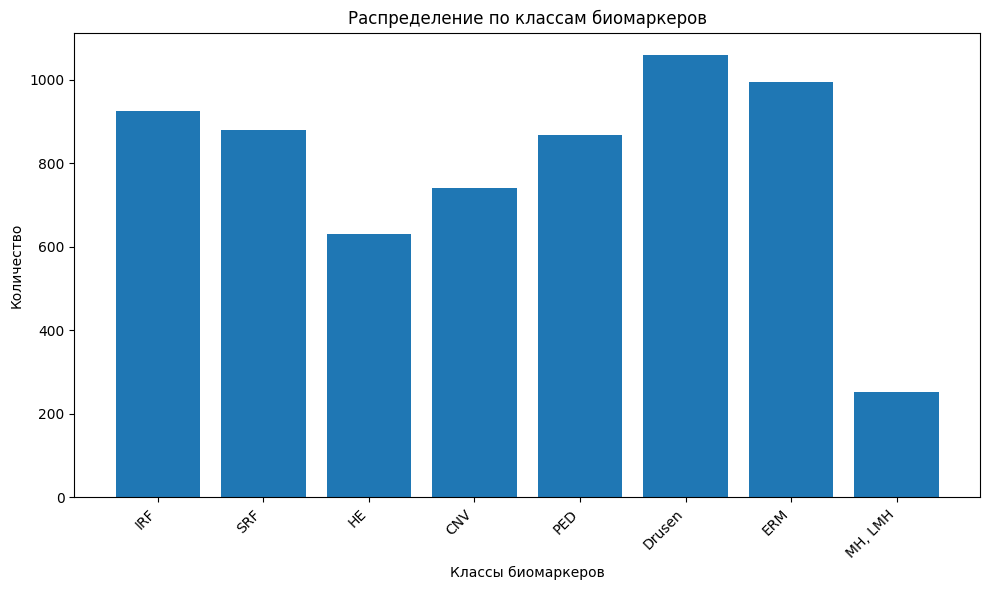

In [ ]:
dataset_no_id = data.remove_columns(["id"]) # Создаем новый Dataset без 'id'

labels = ['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']
def plot_histogram(data_split):
        if not isinstance(data_split, Dataset):
            raise TypeError("data_split must be a Dataset object.")

        class_counts = {
            label: 0 for label in labels
        }

        for i in range(len(data_split)):
            sample = data_split[i]

            for label in labels:
                try:
                    class_counts[label] += sample[label]
                except KeyError as e:
                    print(f"KeyError: {e}. Обратите внимание на структуру данных.")
                    return

        classes = list(class_counts.keys())
        counts = list(class_counts.values())

        plt.figure(figsize=(10, 6))
        plt.bar(classes, counts)
        plt.xlabel('Классы биомаркеров')
        plt.ylabel('Количество')
        plt.title('Распределение по классам биомаркеров')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

plot_histogram(dataset_no_id)


# Совместное рапределение биомаркеров

In [ ]:
from collections import defaultdict
def plot_combined_biomarkers(data_split):
    biomarkers_pairs = defaultdict(int)

    for entry in data_split:
        biomarkers = {key: value for key, value in entry.items() if key in labels}
        active_biomarkers = [biomarkers for biomarkers, value in biomarkers.items() if value > 0]

        for pair in itertools.combinations(sorted(active_biomarkers), 2):
            biomarkers_pairs[pair] += 1

    sorted_pairs = sorted(biomarkers_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(18, 6))
    plt.bar(pairs[:20], counts[:20])
    plt.xlabel('Пары биомаркеров')
    plt.ylabel('Количество')
    plt.title('Совместное появление биомаркеров')
    plt.xticks(rotation=45)

    plt.show()


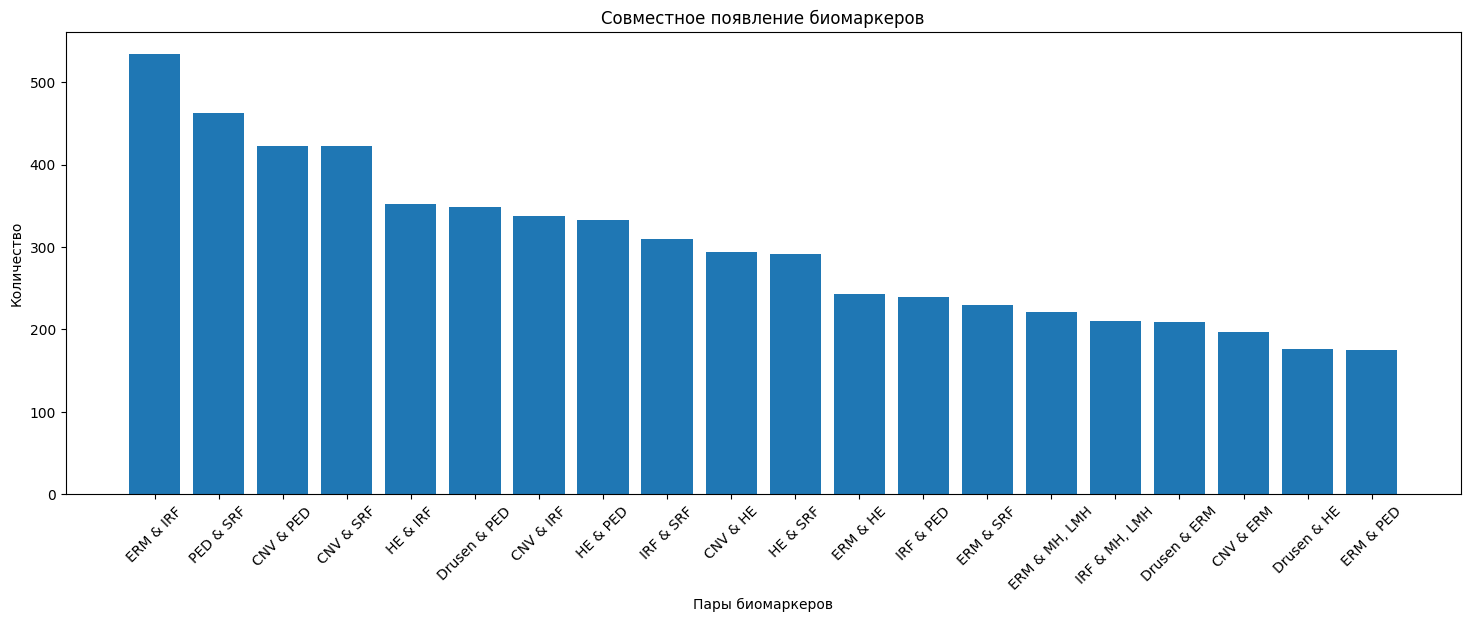

In [ ]:
plot_combined_biomarkers(dataset_no_id)

  # Предварительная обработка данных

In [ ]:
# Custom DataLoader
class CustomDataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = list(range(len(dataset)))
        if shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i >= len(self.indices):
            raise StopIteration

        batch_indices = self.indices[self.i:self.i + self.batch_size]
        self.i += self.batch_size

        batch = [self.dataset[idx] for idx in batch_indices]

        images = [item[0] for item in batch]
        labels = [item[1] for item in batch]


        images = torch.stack(images)
        labels = torch.stack(labels)

        return images, labels, #img_name

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

In [ ]:
class OCTDataset(Dataset):
    def __init__(self, images_dir, labels_file, transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            labels_file (string): Path to the XLSX file with labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_dir = images_dir
        self.labels_df = pd.read_excel(labels_file)
        self.labels_df['id'] = self.labels_df['id'].astype(str)
        self.transform = transform
        self.valid_indices = self._find_valid_indices()
    def _find_valid_indices(self):
        """
        Find indices for which image files exist
        """
        valid_indices = []
        for idx in range(len(self.labels_df)):
            img_name = os.path.join(self.images_dir, f"{self.labels_df['id'].iloc[idx]}.jpg")
            if os.path.exists(img_name):
                valid_indices.append(idx)
        return valid_indices


    def __len__(self):
        return len(self.valid_indices)
    def __getitem__(self, idx):

        real_idx = self.valid_indices[idx]
        img_name = os.path.join(self.images_dir, f"{self.labels_df['id'].iloc[real_idx]}.jpg")

        try:
            image = Image.open(img_name).convert('RGB')
        except FileNotFoundError:
            print(f"Error: File not found at {img_name}")

            image = Image.new('RGB', (224, 224), color='black')
            labels = torch.zeros(12, dtype=torch.float32)
            if self.transform:
                image = self.transform(image)
            return image, labels

        labels = torch.tensor(self.labels_df[['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']].iloc[real_idx].values, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, labels, img_name

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize(180),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
data_transforms_train = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

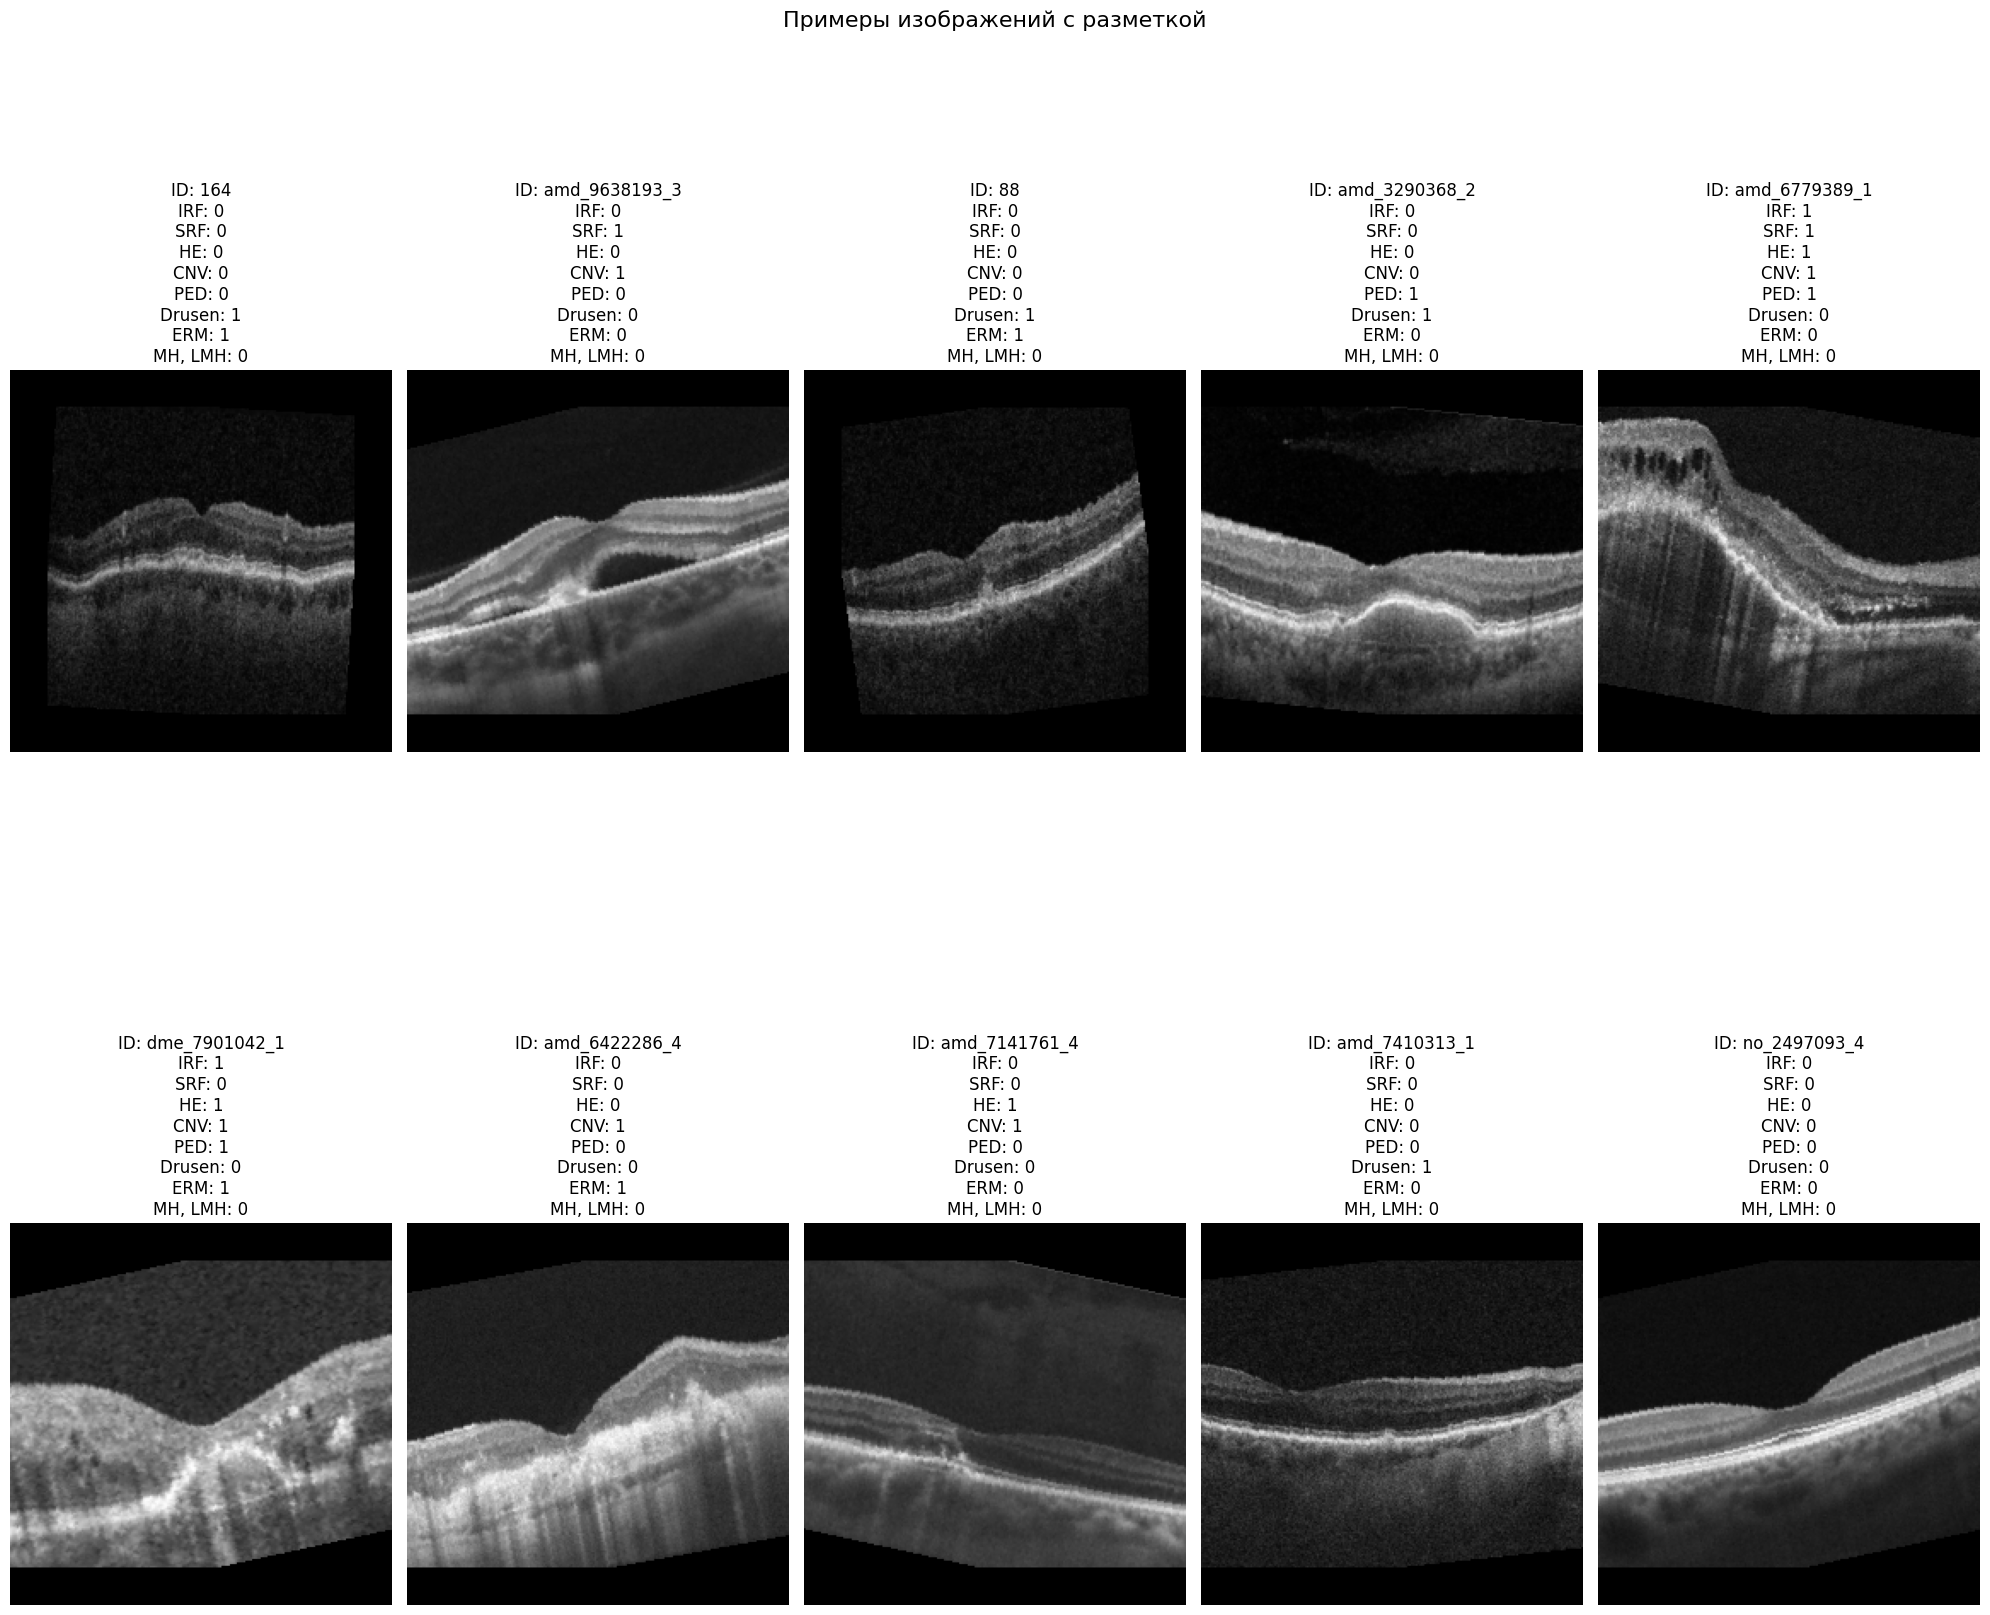

In [ ]:

dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=data_transforms_train

indices = torch.randperm(len(dataset))[:10]

def denormalize(image):
    """Денормализует изображение для отображения"""
    if isinstance(image, torch.Tensor):
        image = image.numpy()




    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image


fig, axes = plt.subplots(2, 5, figsize=(20, 20))
fig.suptitle('Примеры изображений с разметкой', fontsize=16)

for i, idx in enumerate(indices):
    image, label, name = dataset[idx]

    image = denormalize(image)


    label_names = ['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']
    label_text = '\n'.join([f'{n}: {v:.0f}' for n, v in zip(label_names, label.numpy())])


    ax = axes[i//5, i%5]
    ax.imshow(image)
    ax.set_title(f"ID: {dataset.labels_df['id'].iloc[dataset.valid_indices[idx]]}\n{label_text}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# индексы для разделения
dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=None
)

train_size = 0.9
test_size = 0.1

train_idx, test_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=test_size,
    train_size=train_size,
    random_state=42
)

# отдельные датасеты с разными трансформациями
train_dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=data_transforms_train
)
train_dataset = Subset(train_dataset, train_idx)

test_dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/data_jpg1',
    labels_file='/content/data_8_new.xlsx',
    transform=data_transforms
)
test_dataset = Subset(test_dataset, test_idx)


# Проверяем размеры
print(f"Размер тренировочного набора: {len(train_dataset)}")
print(f"Размер тестового набора: {len(test_dataset)}")


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



Размер тренировочного набора: 2821
Размер тестового набора: 314


In [ ]:
# Create CUSTOM data loaders
train_dataloader = CustomDataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True)

test_dataloader = CustomDataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False)

#Обучение модели.

## Загрузка весов модели

In [ ]:
# Инициализация модели
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Заморозка слоев (fine-tuning)
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

Модификация последних слоев с добавлением Dropout
num_classes = 8
num_features = model.fc.in_features

# Новый блок fully connected с Dropout и BatchNorm
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout с вероятностью 50%
    nn.Linear(num_features, 512),  # Промежуточный слой
    nn.BatchNorm1d(512),  # Нормализация
    nn.ReLU(inplace=True),  # Активация
    nn.Dropout(p=0.3),  # Еще один Dropout
    nn.Linear(512, num_classes)  # Финальный слой
)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Обучение и оценка модели

In [ ]:
learning_rate = 1e-7
num_epochs = 20 # на 20 эпохах
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# 12. Цикл обучения
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.float().to(device)


        optimizer.zero_grad()


        outputs = model(images)
        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

     # Валидация
    model.eval()
    all_preds = []
    all_labels = []
    running_corrects = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = (outputs > 0.35).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_running_loss += loss.item() * images.size(0)

            running_corrects += torch.sum(preds == labels.data).item()

    epoch_acc = running_corrects / (len(test_dataset) * num_classes)
    val_epoch_loss = val_running_loss / len(test_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Val Accuracy: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}')


print("Fine-tuning complete!")

Epoch [1/2], Train Loss: 0.1559
Epoch [1/2], Val Accuracy: 0.9061, Val Loss: 0.2333
Epoch [2/2], Train Loss: 0.1560
Epoch [2/2], Val Accuracy: 0.9053, Val Loss: 0.2325
Fine-tuning complete!


In [ ]:
 # Вычисление метрик по классам
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
for i in range(num_classes):
        precision = precision_score(all_labels[:, i], all_preds[:, i])
        recall = recall_score(all_labels[:, i], all_preds[:, i])
        f1 = f1_score(all_labels[:, i], all_preds[:, i])
        print(f'Class {i}: Precision = {precision:.2f}, Recall = {recall:.2f}, F1 = {f1:.2f}')

Class 0: Precision = 0.96, Recall = 0.81, F1 = 0.88
Class 1: Precision = 0.87, Recall = 0.84, F1 = 0.85
Class 2: Precision = 0.74, Recall = 0.51, F1 = 0.60
Class 3: Precision = 0.88, Recall = 0.79, F1 = 0.83
Class 4: Precision = 0.92, Recall = 0.76, F1 = 0.83
Class 5: Precision = 0.90, Recall = 0.74, F1 = 0.81
Class 6: Precision = 0.84, Recall = 0.63, F1 = 0.72
Class 7: Precision = 0.97, Recall = 0.94, F1 = 0.95


In [ ]:
micro_f1 = f1_score(all_labels, all_preds, average='micro')
macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f'Micro F1: {micro_f1:.2f}, Macro F1: {macro_f1:.2f}')

Micro F1: 0.81, Macro F1: 0.81


In [ ]:
torch.save(model.state_dict(), 'model_resnet50_8_best.pth')
print("Модель сохранена в model.pth")

Модель сохранена в model.pth


# Проверка на Валидационном наборе

In [ ]:
val_dataset = OCTDataset(
    images_dir='/content/drive/MyDrive/ОКТ макула (копия)',
    labels_file='/content/OCT_VAL 8.xlsx',
    transform=data_transforms
)

val_dataloader = CustomDataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False)


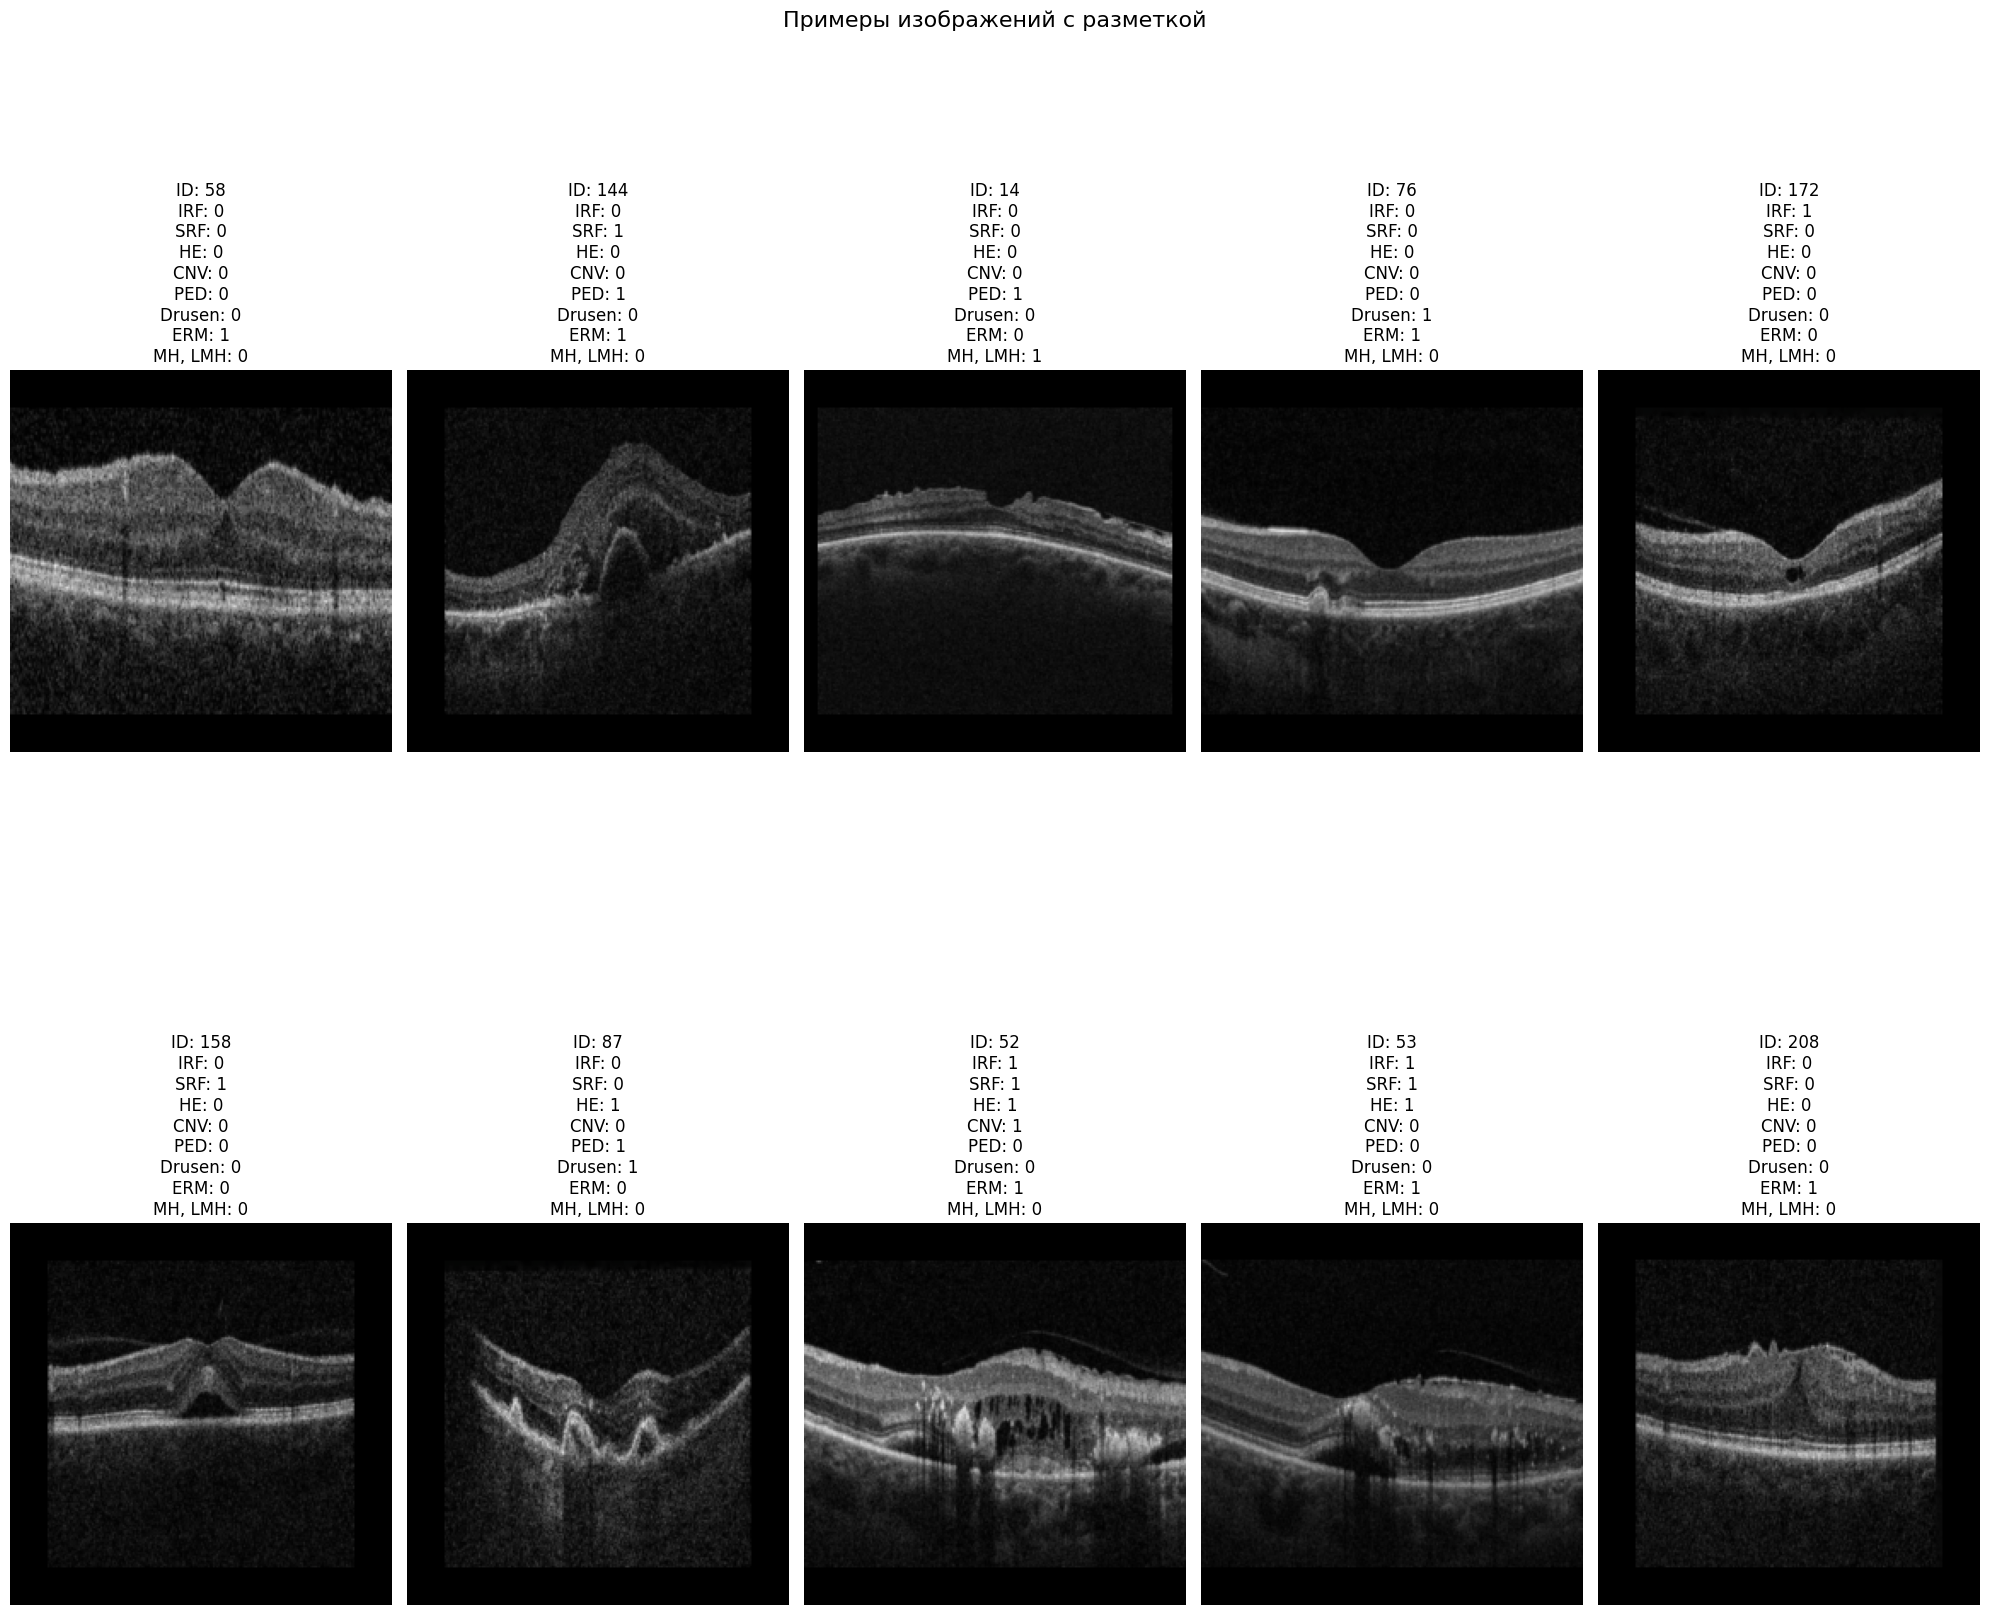

In [ ]:

indices = torch.randperm(len(val_dataset))[:10]


fig, axes = plt.subplots(2, 5, figsize=(20, 20))
fig.suptitle('Примеры изображений с разметкой', fontsize=16)

for i, idx in enumerate(indices):
    image, label,name = val_dataset[idx]


    image = denormalize(image)


    label_names = ['IRF', 'SRF', 'HE', 'CNV', 'PED', 'Drusen', 'ERM', 'MH, LMH']
    label_text = '\n'.join([f'{n}: {v:.0f}' for n, v in zip(label_names, label.numpy())])

    ax = axes[i//5, i%5]
    ax.imshow(image)
    ax.set_title(f"ID: {val_dataset.labels_df['id'].iloc[val_dataset.valid_indices[idx]]}\n{label_text}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)


        preds = (outputs > 0.25).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

for i in range(num_classes):
    precision = precision_score(all_labels[:, i], all_preds[:, i], zero_division=0)
    recall = recall_score(all_labels[:, i], all_preds[:, i])
    f1 = f1_score(all_labels[:, i], all_preds[:, i])
    print(f'Class {i}: Precision = {precision:.2f}, Recall = {recall:.4f}, F1 = {f1:.2f}')

Accuracy: 0.5382
Class 0: Precision = 0.96, Recall = 0.8061, F1 = 0.88
Class 1: Precision = 0.85, Recall = 0.8462, F1 = 0.85
Class 2: Precision = 0.74, Recall = 0.5072, F1 = 0.60
Class 3: Precision = 0.88, Recall = 0.8056, F1 = 0.84
Class 4: Precision = 0.91, Recall = 0.7802, F1 = 0.84
Class 5: Precision = 0.90, Recall = 0.7333, F1 = 0.81
Class 6: Precision = 0.84, Recall = 0.6538, F1 = 0.74
Class 7: Precision = 0.97, Recall = 0.9355, F1 = 0.95


In [ ]:
micro_f1 = f1_score(all_labels, all_preds, average='micro')
macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f'Micro F1: {micro_f1:.2f}, Macro F1: {macro_f1:.2f}')

Micro F1: 0.81, Macro F1: 0.81


In [ ]:
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_bootstrap_ci_multilabel(y_true, y_pred, n_iterations=1000, confidence_interval=95):
    """
    Вычисляет бутстрапные доверительные интервалы в формате "mean ± interval".
    Возвращает словарь с:
    - средними значениями метрик (mean)
    - полушириной доверительного интервала (interval)
    - отформатированными строками (print_ci)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n_samples = len(y_true)
    num_classes = y_true.shape[1]

    # Инициализация массивов
    precision_per_class = np.zeros((n_iterations, num_classes))
    recall_per_class = np.zeros((n_iterations, num_classes))
    f1_per_class = np.zeros((n_iterations, num_classes))

    micro_precision, micro_recall, micro_f1 = np.zeros(n_iterations), np.zeros(n_iterations), np.zeros(n_iterations)
    macro_precision, macro_recall, macro_f1 = np.zeros(n_iterations), np.zeros(n_iterations), np.zeros(n_iterations)

    for i in range(n_iterations):
        indices = resample(np.arange(n_samples), replace=True, n_samples=n_samples)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]

        precision_per_class[i] = precision_score(y_true_sample, y_pred_sample, average=None, zero_division=0)
        recall_per_class[i] = recall_score(y_true_sample, y_pred_sample, average=None, zero_division=0)
        f1_per_class[i] = f1_score(y_true_sample, y_pred_sample, average=None, zero_division=0)

        micro_precision[i] = precision_score(y_true_sample, y_pred_sample, average='micro', zero_division=0)
        micro_recall[i] = recall_score(y_true_sample, y_pred_sample, average='micro', zero_division=0)
        micro_f1[i] = f1_score(y_true_sample, y_pred_sample, average='micro', zero_division=0)

        macro_precision[i] = precision_score(y_true_sample, y_pred_sample, average='macro', zero_division=0)
        macro_recall[i] = recall_score(y_true_sample, y_pred_sample, average='macro', zero_division=0)
        macro_f1[i] = f1_score(y_true_sample, y_pred_sample, average='macro', zero_division=0)

    alpha = (100 - confidence_interval) / 2
    percentiles = (alpha, 100 - alpha)

    def _get_ci(metric_values):
        mean = np.mean(metric_values)
        lower, upper = np.percentile(metric_values, percentiles)
        interval = (upper - lower) / 2
        return {
            'mean': mean,
            'interval': interval,
            'print_ci': f"{mean:.4f} ± {interval:.4f}"
        }

    result = {
        'per_class': {},
        'micro': {},
        'macro': {}
    }

    # Для каждого класса
    for class_id in range(num_classes):
        result['per_class'][class_id] = {
            'precision': _get_ci(precision_per_class[:, class_id]),
            'recall': _get_ci(recall_per_class[:, class_id]),
            'f1': _get_ci(f1_per_class[:, class_id])
        }

    # Для микро-усреднения
    result['micro'] = {
        'precision': _get_ci(micro_precision),
        'recall': _get_ci(micro_recall),
        'f1': _get_ci(micro_f1)
    }

    # Для макро-усреднения
    result['macro'] = {
        'precision': _get_ci(macro_precision),
        'recall': _get_ci(macro_recall),
        'f1': _get_ci(macro_f1)
    }

    return result



ci = calculate_bootstrap_ci_multilabel(all_labels, all_preds)
print("=== Per-class metrics ===")
for class_id in ci['per_class']:
      print(f"\nClass {class_id}:")
      print(f"Precision: {ci['per_class'][class_id]['precision']['print_ci']}")
      print(f"Recall:    {ci['per_class'][class_id]['recall']['print_ci']}")
      print(f"F1-score:  {ci['per_class'][class_id]['f1']['print_ci']}")
print("\n=== Micro-averaged metrics ===")
print(f"Precision: {ci['micro']['precision']['print_ci']}")
print(f"Recall:    {ci['micro']['recall']['print_ci']}")
print(f"F1-score:  {ci['micro']['f1']['print_ci']}")

print("\n=== Macro-averaged metrics ===")
print(f"Precision: {ci['macro']['precision']['print_ci']}")
print(f"Recall:    {ci['macro']['recall']['print_ci']}")
print(f"F1-score:  {ci['macro']['f1']['print_ci']}")


=== Per-class metrics ===

Class 0:
Precision: 0.9631 ± 0.0282
Recall:    0.8059 ± 0.0543
F1-score:  0.8772 ± 0.0359

Class 1:
Precision: 0.8454 ± 0.0525
Recall:    0.8465 ± 0.0509
F1-score:  0.8456 ± 0.0405

Class 2:
Precision: 0.7429 ± 0.0870
Recall:    0.5074 ± 0.0854
F1-score:  0.6019 ± 0.0718

Class 3:
Precision: 0.8784 ± 0.0563
Recall:    0.8062 ± 0.0631
F1-score:  0.8403 ± 0.0488

Class 4:
Precision: 0.9102 ± 0.0446
Recall:    0.7799 ± 0.0594
F1-score:  0.8396 ± 0.0413

Class 5:
Precision: 0.8952 ± 0.0458
Recall:    0.7342 ± 0.0616
F1-score:  0.8063 ± 0.0448

Class 6:
Precision: 0.8410 ± 0.0550
Recall:    0.6525 ± 0.0650
F1-score:  0.7344 ± 0.0512

Class 7:
Precision: 0.9668 ± 0.0431
Recall:    0.9368 ± 0.0584
F1-score:  0.9512 ± 0.0396

=== Micro-averaged metrics ===
Precision: 0.8804 ± 0.0182
Recall:    0.7474 ± 0.0254
F1-score:  0.8084 ± 0.0181

=== Macro-averaged metrics ===
Precision: 0.8804 ± 0.0193
Recall:    0.7587 ± 0.0244
F1-score:  0.8121 ± 0.0180


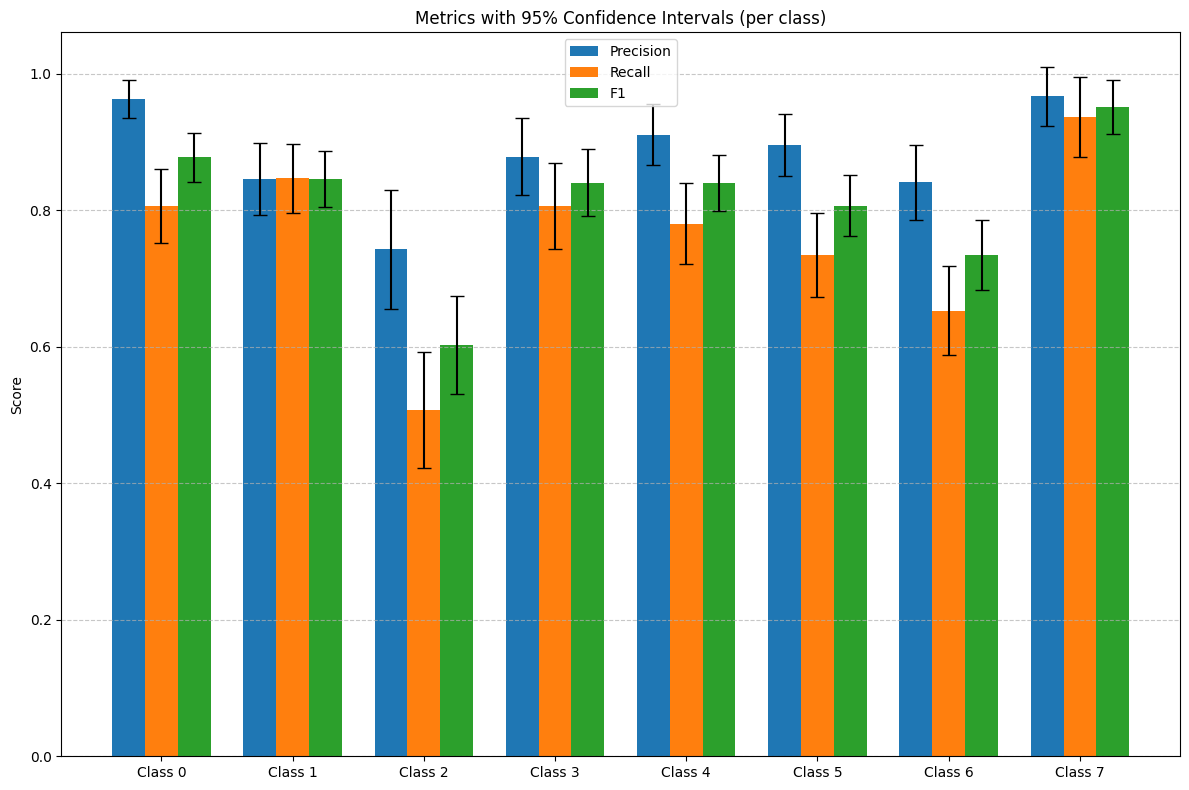

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Собираем данные в DataFrame
metrics = []
for class_id in ci['per_class']:
    for metric in ['precision', 'recall', 'f1']:
        metrics.append({
            'Class': f'Class {class_id}',
            'Metric': metric.capitalize(),
            'Mean': ci['per_class'][class_id][metric]['mean'],
            'CI': ci['per_class'][class_id][metric]['interval']
        })

df = pd.DataFrame(metrics)

# Создаем bar plot с error bars
plt.figure(figsize=(12, 8))
for i, metric in enumerate(['Precision', 'Recall', 'F1']):
    subset = df[df['Metric'] == metric]
    plt.bar(np.arange(len(subset)) + i*0.25, subset['Mean'],
            width=0.25, label=metric, yerr=subset['CI'], capsize=5)

plt.xticks(np.arange(len(ci['per_class'])) + 0.25, [f'Class {i}' for i in ci['per_class']])
plt.ylabel('Score')
plt.title('Metrics with 95% Confidence Intervals (per class)')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Бинаризация меток для многоклассового случая
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2,3,4,5,6,7])

# Расчет ROC AUC для каждого класса
auc_all= []
for i in range(y_true_bin.shape[1]):
    auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
    print(f"ROC AUC для класса {i}: {auc:.2f}")
    auc_all.append(auc)

ROC AUC для класса 0: 0.90
ROC AUC для класса 1: 0.89
ROC AUC для класса 2: 0.73
ROC AUC для класса 3: 0.89
ROC AUC для класса 4: 0.87
ROC AUC для класса 5: 0.85
ROC AUC для класса 6: 0.80
ROC AUC для класса 7: 0.97


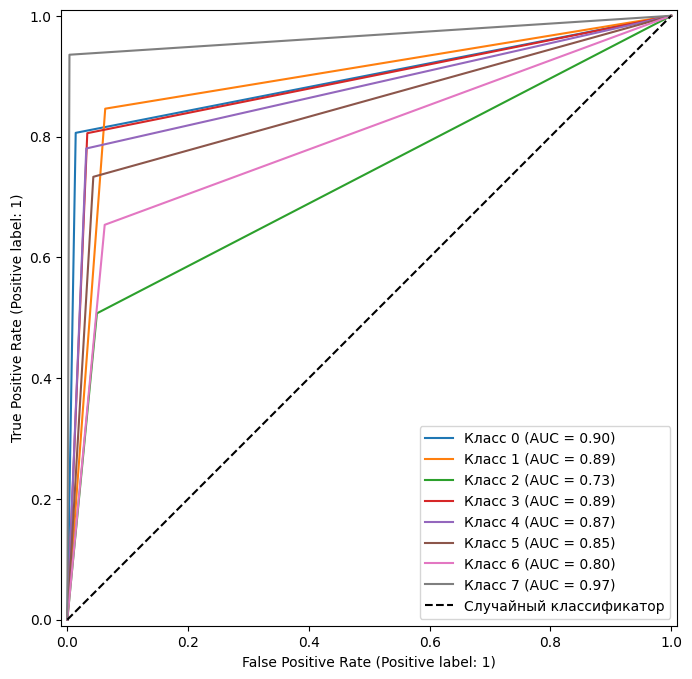

In [ ]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(8):
    RocCurveDisplay.from_predictions(
        y_true_bin[:, i],
        all_preds[:, i],
        name=f"Класс {i}",
        ax=ax
    )
plt.plot([0, 1], [0, 1], "k--", label="Случайный классификатор")
plt.legend()
plt.show()